# Define KAN model architecture


In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.optim as optim
from torchvision import datasets, transforms
import random
import numpy as np
import argparse
import torch.nn.functional as F
import math
from typing import List, Tuple, Union
import warnings
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm

class KANLinear(torch.nn.Module):
    def __init__(
        self,
        in_features,
        out_features,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        enable_standalone_scale_spline=True,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KANLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order

        h = (grid_range[1] - grid_range[0]) / grid_size
        grid = (
            (
                torch.arange(-spline_order, grid_size + spline_order + 1) * h
                + grid_range[0]
            )
            .expand(in_features, -1)
            .contiguous()
        )
        self.register_buffer("grid", grid)

        self.base_weight = torch.nn.Parameter(torch.Tensor(out_features, in_features))
        self.spline_weight = torch.nn.Parameter(
            torch.Tensor(out_features, in_features, grid_size + spline_order)
        )
        if enable_standalone_scale_spline:
            self.spline_scaler = torch.nn.Parameter(
                torch.Tensor(out_features, in_features)
            )

        self.scale_noise = scale_noise
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.base_activation = base_activation()
        self.grid_eps = grid_eps

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * self.scale_base)
        with torch.no_grad():
            noise = (
                (
                    torch.rand(self.grid_size + 1, self.in_features, self.out_features)
                    - 1 / 2
                )
                * self.scale_noise
                / self.grid_size
            )
            self.spline_weight.data.copy_(
                (self.scale_spline if not self.enable_standalone_scale_spline else 1.0)
                * self.curve2coeff(
                    self.grid.T[self.spline_order : -self.spline_order],
                    noise,
                )
            )
            if self.enable_standalone_scale_spline:
                # torch.nn.init.constant_(self.spline_scaler, self.scale_spline)
                torch.nn.init.kaiming_uniform_(self.spline_scaler, a=math.sqrt(5) * self.scale_spline)

    def b_splines(self, x: torch.Tensor):
        """
        Compute the B-spline bases for the given input tensor.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).

        Returns:
            torch.Tensor: B-spline bases tensor of shape (batch_size, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features

        grid: torch.Tensor = (
            self.grid
        )  # (in_features, grid_size + 2 * spline_order + 1)
        x = x.unsqueeze(-1)
        bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)
        for k in range(1, self.spline_order + 1):
            bases = (
                (x - grid[:, : -(k + 1)])
                / (grid[:, k:-1] - grid[:, : -(k + 1)])
                * bases[:, :, :-1]
            ) + (
                (grid[:, k + 1 :] - x)
                / (grid[:, k + 1 :] - grid[:, 1:(-k)])
                * bases[:, :, 1:]
            )

        assert bases.size() == (
            x.size(0),
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return bases.contiguous()

    def curve2coeff(self, x: torch.Tensor, y: torch.Tensor):
        """
        Compute the coefficients of the curve that interpolates the given points.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).
            y (torch.Tensor): Output tensor of shape (batch_size, in_features, out_features).

        Returns:
            torch.Tensor: Coefficients tensor of shape (out_features, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features
        assert y.size() == (x.size(0), self.in_features, self.out_features)

        A = self.b_splines(x).transpose(
            0, 1
        )  # (in_features, batch_size, grid_size + spline_order)
        B = y.transpose(0, 1)  # (in_features, batch_size, out_features)
        solution = torch.linalg.lstsq(
            A, B
        ).solution  # (in_features, grid_size + spline_order, out_features)
        result = solution.permute(
            2, 0, 1
        )  # (out_features, in_features, grid_size + spline_order)

        assert result.size() == (
            self.out_features,
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return result.contiguous()

    @property
    def scaled_spline_weight(self):
        return self.spline_weight * (
            self.spline_scaler.unsqueeze(-1)
            if self.enable_standalone_scale_spline
            else 1.0
        )

    def forward(self, x: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features

        base_output = F.linear(self.base_activation(x), self.base_weight)
        spline_output = F.linear(
            self.b_splines(x).view(x.size(0), -1),
            self.scaled_spline_weight.view(self.out_features, -1),
        )
        return base_output + spline_output

    @torch.no_grad()
    def update_grid(self, x: torch.Tensor, margin=0.01):
        assert x.dim() == 2 and x.size(1) == self.in_features
        batch = x.size(0)

        splines = self.b_splines(x)  # (batch, in, coeff)
        splines = splines.permute(1, 0, 2)  # (in, batch, coeff)
        orig_coeff = self.scaled_spline_weight  # (out, in, coeff)
        orig_coeff = orig_coeff.permute(1, 2, 0)  # (in, coeff, out)
        unreduced_spline_output = torch.bmm(splines, orig_coeff)  # (in, batch, out)
        unreduced_spline_output = unreduced_spline_output.permute(
            1, 0, 2
        )  # (batch, in, out)

        # sort each channel individually to collect data distribution
        x_sorted = torch.sort(x, dim=0)[0]
        grid_adaptive = x_sorted[
            torch.linspace(
                0, batch - 1, self.grid_size + 1, dtype=torch.int64, device=x.device
            )
        ]

        uniform_step = (x_sorted[-1] - x_sorted[0] + 2 * margin) / self.grid_size
        grid_uniform = (
            torch.arange(
                self.grid_size + 1, dtype=torch.float32, device=x.device
            ).unsqueeze(1)
            * uniform_step
            + x_sorted[0]
            - margin
        )

        grid = self.grid_eps * grid_uniform + (1 - self.grid_eps) * grid_adaptive
        grid = torch.concatenate(
            [
                grid[:1]
                - uniform_step
                * torch.arange(self.spline_order, 0, -1, device=x.device).unsqueeze(1),
                grid,
                grid[-1:]
                + uniform_step
                * torch.arange(1, self.spline_order + 1, device=x.device).unsqueeze(1),
            ],
            dim=0,
        )

        self.grid.copy_(grid.T)
        self.spline_weight.data.copy_(self.curve2coeff(x, unreduced_spline_output))

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        """
        Compute the regularization loss.

        This is a dumb simulation of the original L1 regularization as stated in the
        paper, since the original one requires computing absolutes and entropy from the
        expanded (batch, in_features, out_features) intermediate tensor, which is hidden
        behind the F.linear function if we want an memory efficient implementation.

        The L1 regularization is now computed as mean absolute value of the spline
        weights. The authors implementation also includes this term in addition to the
        sample-based regularization.
        """
        l1_fake = self.spline_weight.abs().mean(-1)
        regularization_loss_activation = l1_fake.sum()
        p = l1_fake / regularization_loss_activation
        regularization_loss_entropy = -torch.sum(p * p.log())
        return (
            regularize_activation * regularization_loss_activation
            + regularize_entropy * regularization_loss_entropy
        )


class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction, in_channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)


class ResidualBlock(nn.Module):
    def __init__(self, in_ch, out_ch, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_ch)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_ch != out_ch:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=stride, padding=0),
                nn.BatchNorm2d(out_ch)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out



class ResEmoteNetKAN(nn.Module):
    def __init__(self, dropout_rate=0.3):
        super(ResEmoteNetKAN, self).__init__()
        # Initial layers with gradual channel increase
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # Reduced from 128
        self.bn3 = nn.BatchNorm2d(128)
        
        # SE blocks after each major block
        self.se1 = SEBlock(128)
        self.se2 = SEBlock(256)
        self.se3 = SEBlock(512)
        
        # Modified residual blocks with smoother transitions
        self.res_block1 = ResidualBlock(128, 256, stride=2)
        self.res_block2 = ResidualBlock(256, 512, stride=2)
        self.res_block3 = ResidualBlock(512, 1024, stride=2)  # Reduced from 1024
        
        # Global pooling
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Modified KAN layers with batch norm and smoother transitions
        self.kan_block1 = KANLinear(1024,512)
        self.kan_block2 = KANLinear(512,256)
        self.kan_block3 = KANLinear(256,128)
        
        # self.kan_block2 = nn.Sequential(
        #     FastKANLayer(512, 256),
        #     nn.BatchNorm1d(256),
        #     nn.ReLU(),
        #     nn.Dropout(dropout_rate)
        # )
        
        # self.kan_block3 = nn.Sequential(
        #     FastKANLayer(256, 128),
        #     nn.BatchNorm1d(128),
        #     nn.ReLU(),
        #     nn.Dropout(dropout_rate)
        # )
        
        # Final classification layer with reduced complexity
        self.classifier = KANLinear(128, 7)
        
    #     # Initialize weights
    #     self._initialize_weights()
    
    # def _initialize_weights(self):
    #     for m in self.modules():
    #         if isinstance(m, (nn.Conv2d, SplineConv2D)):
    #             nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
    #             if m.bias is not None:
    #                 nn.init.constant_(m.bias, 0)
    #         elif isinstance(m, nn.BatchNorm2d):
    #             nn.init.constant_(m.weight, 1)
    #             nn.init.constant_(m.bias, 0)
    #         elif isinstance(m, nn.Linear):
    #             nn.init.normal_(m.weight, 0, 0.01)
    #             if m.bias is not None:
    #                 nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # Initial convolutions with activation and pooling
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.se1(x)
        x = F.max_pool2d(x, 2)
        
        # Residual blocks with SE attention
        x = self.res_block1(x)
        x = self.se2(x)
        
        x = self.res_block2(x)
        x = self.se3(x)
        
        x = self.res_block3(x)
        
        # Global pooling and flatten
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        
        # KAN blocks with batch norm and dropout
        x = self.kan_block1(x)
        x = self.kan_block2(x)
        x = self.kan_block3(x)
        
        # Final classification
        x = self.classifier(x)
        
        return x

# Training KAN Model

In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

# Define transforms
train_transform = transforms.Compose([
    transforms.Resize((48, 48)),  # Standard size for FER2013
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Grayscale normalization
])

test_transform = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Load datasets
train_dataset = datasets.ImageFolder(
    root='/kaggle/input/fer2013/train',
    transform=train_transform
)

val_dataset = datasets.ImageFolder(
    root='/kaggle/input/fer2013/test',  
    transform=test_transform
)

BATCH_SIZE = 16

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

# Initialize model, criterion, and optimizer
model = ResEmoteNetKAN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)

# Print dataset sizes
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")

# Training parameters
num_epochs = 80
patience = 15
best_val_acc = 0
patience_counter = 0
epoch_counter = 0

# History tracking
history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        train_total += labels.size(0)
        train_correct += predicted.eq(labels).sum().item()
        
        # Update progress bar
        pbar.set_postfix({
            'loss': f'{train_loss/train_total:.4f}',
            'acc': f'{100.*train_correct/train_total:.2f}%'
        })
    
    train_loss = train_loss / len(train_loader)
    train_acc = train_correct / train_total
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc='Validation'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()
    
    val_loss = val_loss / len(val_loader)
    val_acc = val_correct / val_total
    
    # Store history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    print(f'\nEpoch {epoch+1}:')
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
    
    # Early stopping check
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        # Save the best model
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_acc': best_val_acc,
        }, 'ResEmoteNetKAN_model.pth')
    else:
        patience_counter += 1
        print(f'No improvement for {patience_counter} epochs.')
        
    if patience_counter >= patience:
        print('Early stopping triggered.')
        break
    
    epoch_counter += 1

# Save final results
num_epochs_completed = len(history['train_loss'])  # Menggunakan panjang aktual dari history
results_df = pd.DataFrame({
    'Epoch': range(1, num_epochs_completed + 1),
    'Train Loss': history['train_loss'],
    'Val Loss': history['val_loss'],
    'Train Acc': history['train_acc'],
    'Val Acc': history['val_acc']
})
results_df.to_csv('training_history.csv', index=False)

Using cuda device
Training set size: 28709
Validation set size: 7178


Validation: 100%|██████████| 449/449 [00:16<00:00, 26.72it/s]



Epoch 1:
Train Loss: 1.6654, Train Acc: 0.3228
Val Loss: 1.4904, Val Acc: 0.4000


Validation: 100%|██████████| 449/449 [00:05<00:00, 78.20it/s]



Epoch 2:
Train Loss: 1.4929, Train Acc: 0.4065
Val Loss: 1.4330, Val Acc: 0.4486


Validation: 100%|██████████| 449/449 [00:05<00:00, 79.89it/s]



Epoch 3:
Train Loss: 1.3965, Train Acc: 0.4528
Val Loss: 1.2923, Val Acc: 0.4921


Validation: 100%|██████████| 449/449 [00:05<00:00, 79.49it/s]



Epoch 4:
Train Loss: 1.3306, Train Acc: 0.4803
Val Loss: 1.2623, Val Acc: 0.5042


Validation: 100%|██████████| 449/449 [00:05<00:00, 80.78it/s]



Epoch 5:
Train Loss: 1.2905, Train Acc: 0.5037
Val Loss: 1.2388, Val Acc: 0.5208


Validation: 100%|██████████| 449/449 [00:05<00:00, 80.85it/s]



Epoch 6:
Train Loss: 1.2504, Train Acc: 0.5172
Val Loss: 1.1915, Val Acc: 0.5355


Validation: 100%|██████████| 449/449 [00:05<00:00, 78.47it/s]



Epoch 7:
Train Loss: 1.2246, Train Acc: 0.5289
Val Loss: 1.1656, Val Acc: 0.5549


Validation: 100%|██████████| 449/449 [00:05<00:00, 77.96it/s]



Epoch 8:
Train Loss: 1.1968, Train Acc: 0.5436
Val Loss: 1.1492, Val Acc: 0.5577


Validation: 100%|██████████| 449/449 [00:05<00:00, 80.70it/s]



Epoch 9:
Train Loss: 1.1697, Train Acc: 0.5580
Val Loss: 1.1224, Val Acc: 0.5691


Validation: 100%|██████████| 449/449 [00:05<00:00, 77.35it/s]



Epoch 10:
Train Loss: 1.1431, Train Acc: 0.5695
Val Loss: 1.1179, Val Acc: 0.5783


Validation: 100%|██████████| 449/449 [00:06<00:00, 74.38it/s]



Epoch 11:
Train Loss: 1.1182, Train Acc: 0.5757
Val Loss: 1.0994, Val Acc: 0.5836


Validation: 100%|██████████| 449/449 [00:05<00:00, 81.02it/s]



Epoch 12:
Train Loss: 1.0980, Train Acc: 0.5837
Val Loss: 1.0855, Val Acc: 0.5893


Validation: 100%|██████████| 449/449 [00:05<00:00, 79.69it/s]



Epoch 13:
Train Loss: 1.0812, Train Acc: 0.5931
Val Loss: 1.0781, Val Acc: 0.5926


Validation: 100%|██████████| 449/449 [00:05<00:00, 81.73it/s]



Epoch 14:
Train Loss: 1.0560, Train Acc: 0.6054
Val Loss: 1.0915, Val Acc: 0.5963


Validation: 100%|██████████| 449/449 [00:05<00:00, 81.23it/s]



Epoch 15:
Train Loss: 1.0402, Train Acc: 0.6102
Val Loss: 1.0457, Val Acc: 0.6087


Validation: 100%|██████████| 449/449 [00:05<00:00, 80.65it/s]



Epoch 16:
Train Loss: 1.0181, Train Acc: 0.6230
Val Loss: 1.0627, Val Acc: 0.6028
No improvement for 1 epochs.


Validation: 100%|██████████| 449/449 [00:05<00:00, 80.43it/s]



Epoch 17:
Train Loss: 1.0001, Train Acc: 0.6273
Val Loss: 1.0462, Val Acc: 0.6081
No improvement for 2 epochs.


Validation: 100%|██████████| 449/449 [00:06<00:00, 73.43it/s]



Epoch 18:
Train Loss: 0.9853, Train Acc: 0.6367
Val Loss: 1.0477, Val Acc: 0.6094


Validation: 100%|██████████| 449/449 [00:06<00:00, 70.73it/s]



Epoch 19:
Train Loss: 0.9709, Train Acc: 0.6404
Val Loss: 1.0196, Val Acc: 0.6197


Validation: 100%|██████████| 449/449 [00:05<00:00, 80.78it/s]



Epoch 20:
Train Loss: 0.9500, Train Acc: 0.6497
Val Loss: 1.0155, Val Acc: 0.6206


Validation: 100%|██████████| 449/449 [00:05<00:00, 81.38it/s]



Epoch 21:
Train Loss: 0.9383, Train Acc: 0.6508
Val Loss: 1.0180, Val Acc: 0.6273


Validation: 100%|██████████| 449/449 [00:05<00:00, 80.36it/s]



Epoch 22:
Train Loss: 0.9188, Train Acc: 0.6591
Val Loss: 1.0146, Val Acc: 0.6251
No improvement for 1 epochs.


Validation: 100%|██████████| 449/449 [00:05<00:00, 81.47it/s]



Epoch 23:
Train Loss: 0.9015, Train Acc: 0.6684
Val Loss: 1.0204, Val Acc: 0.6268
No improvement for 2 epochs.


Validation: 100%|██████████| 449/449 [00:05<00:00, 81.95it/s]



Epoch 24:
Train Loss: 0.8916, Train Acc: 0.6726
Val Loss: 1.0083, Val Acc: 0.6290


Validation: 100%|██████████| 449/449 [00:05<00:00, 81.12it/s]



Epoch 25:
Train Loss: 0.8798, Train Acc: 0.6776
Val Loss: 1.0144, Val Acc: 0.6283
No improvement for 1 epochs.


Validation: 100%|██████████| 449/449 [00:05<00:00, 81.03it/s]



Epoch 26:
Train Loss: 0.8573, Train Acc: 0.6877
Val Loss: 0.9860, Val Acc: 0.6349


Validation: 100%|██████████| 449/449 [00:05<00:00, 80.13it/s]



Epoch 27:
Train Loss: 0.8470, Train Acc: 0.6889
Val Loss: 1.0218, Val Acc: 0.6266
No improvement for 1 epochs.


Validation: 100%|██████████| 449/449 [00:05<00:00, 82.58it/s]



Epoch 28:
Train Loss: 0.8294, Train Acc: 0.6933
Val Loss: 1.0098, Val Acc: 0.6404


Validation: 100%|██████████| 449/449 [00:05<00:00, 80.50it/s]



Epoch 29:
Train Loss: 0.8224, Train Acc: 0.6981
Val Loss: 1.0151, Val Acc: 0.6362
No improvement for 1 epochs.


Validation: 100%|██████████| 449/449 [00:05<00:00, 78.92it/s]



Epoch 30:
Train Loss: 0.8160, Train Acc: 0.7001
Val Loss: 0.9986, Val Acc: 0.6403
No improvement for 2 epochs.


Validation: 100%|██████████| 449/449 [00:05<00:00, 75.48it/s]



Epoch 31:
Train Loss: 0.7926, Train Acc: 0.7114
Val Loss: 1.0174, Val Acc: 0.6374
No improvement for 3 epochs.


Validation: 100%|██████████| 449/449 [00:05<00:00, 77.11it/s]



Epoch 32:
Train Loss: 0.7836, Train Acc: 0.7157
Val Loss: 1.0116, Val Acc: 0.6424


Validation: 100%|██████████| 449/449 [00:05<00:00, 78.26it/s]



Epoch 33:
Train Loss: 0.7577, Train Acc: 0.7233
Val Loss: 1.0260, Val Acc: 0.6346
No improvement for 1 epochs.


Validation: 100%|██████████| 449/449 [00:05<00:00, 77.31it/s]



Epoch 34:
Train Loss: 0.7580, Train Acc: 0.7246
Val Loss: 0.9942, Val Acc: 0.6434


Validation: 100%|██████████| 449/449 [00:05<00:00, 80.08it/s]



Epoch 35:
Train Loss: 0.7496, Train Acc: 0.7265
Val Loss: 1.0185, Val Acc: 0.6431
No improvement for 1 epochs.


Validation: 100%|██████████| 449/449 [00:05<00:00, 81.74it/s]



Epoch 36:
Train Loss: 0.7245, Train Acc: 0.7390
Val Loss: 1.0672, Val Acc: 0.6272
No improvement for 2 epochs.


Validation: 100%|██████████| 449/449 [00:05<00:00, 81.52it/s]



Epoch 37:
Train Loss: 0.7197, Train Acc: 0.7384
Val Loss: 1.0256, Val Acc: 0.6389
No improvement for 3 epochs.


Validation: 100%|██████████| 449/449 [00:05<00:00, 80.33it/s]



Epoch 38:
Train Loss: 0.6991, Train Acc: 0.7484
Val Loss: 1.0591, Val Acc: 0.6441


Validation: 100%|██████████| 449/449 [00:05<00:00, 82.67it/s]



Epoch 39:
Train Loss: 0.6921, Train Acc: 0.7505
Val Loss: 1.0721, Val Acc: 0.6386
No improvement for 1 epochs.


Validation: 100%|██████████| 449/449 [00:05<00:00, 76.79it/s]



Epoch 40:
Train Loss: 0.6822, Train Acc: 0.7537
Val Loss: 1.0463, Val Acc: 0.6454


Validation: 100%|██████████| 449/449 [00:05<00:00, 77.07it/s]



Epoch 41:
Train Loss: 0.6693, Train Acc: 0.7593
Val Loss: 1.0506, Val Acc: 0.6453
No improvement for 1 epochs.


Validation: 100%|██████████| 449/449 [00:05<00:00, 77.66it/s]



Epoch 42:
Train Loss: 0.6541, Train Acc: 0.7631
Val Loss: 1.1151, Val Acc: 0.6399
No improvement for 2 epochs.


Validation: 100%|██████████| 449/449 [00:05<00:00, 80.20it/s]



Epoch 43:
Train Loss: 0.6465, Train Acc: 0.7660
Val Loss: 1.0504, Val Acc: 0.6438
No improvement for 3 epochs.


Validation: 100%|██████████| 449/449 [00:05<00:00, 81.32it/s]



Epoch 44:
Train Loss: 0.6321, Train Acc: 0.7739
Val Loss: 1.1226, Val Acc: 0.6388
No improvement for 4 epochs.


Validation: 100%|██████████| 449/449 [00:05<00:00, 82.05it/s]



Epoch 45:
Train Loss: 0.6396, Train Acc: 0.7707
Val Loss: 1.0692, Val Acc: 0.6431
No improvement for 5 epochs.


Validation: 100%|██████████| 449/449 [00:05<00:00, 84.53it/s]



Epoch 46:
Train Loss: 0.6203, Train Acc: 0.7774
Val Loss: 1.0848, Val Acc: 0.6520


Validation: 100%|██████████| 449/449 [00:05<00:00, 78.40it/s]



Epoch 47:
Train Loss: 0.6009, Train Acc: 0.7862
Val Loss: 1.1194, Val Acc: 0.6450
No improvement for 1 epochs.


Validation: 100%|██████████| 449/449 [00:05<00:00, 78.21it/s]



Epoch 48:
Train Loss: 0.5924, Train Acc: 0.7888
Val Loss: 1.1391, Val Acc: 0.6421
No improvement for 2 epochs.


Validation: 100%|██████████| 449/449 [00:05<00:00, 79.50it/s]



Epoch 49:
Train Loss: 0.5820, Train Acc: 0.7918
Val Loss: 1.1283, Val Acc: 0.6431
No improvement for 3 epochs.


Validation: 100%|██████████| 449/449 [00:05<00:00, 82.31it/s]



Epoch 50:
Train Loss: 0.5760, Train Acc: 0.7968
Val Loss: 1.1699, Val Acc: 0.6457
No improvement for 4 epochs.


Validation: 100%|██████████| 449/449 [00:05<00:00, 78.16it/s]



Epoch 51:
Train Loss: 0.5624, Train Acc: 0.7986
Val Loss: 1.1355, Val Acc: 0.6407
No improvement for 5 epochs.


Validation: 100%|██████████| 449/449 [00:05<00:00, 78.53it/s]



Epoch 52:
Train Loss: 0.5500, Train Acc: 0.8032
Val Loss: 1.1424, Val Acc: 0.6438
No improvement for 6 epochs.


Validation: 100%|██████████| 449/449 [00:05<00:00, 76.31it/s]



Epoch 53:
Train Loss: 0.5505, Train Acc: 0.8029
Val Loss: 1.1619, Val Acc: 0.6492
No improvement for 7 epochs.


Validation: 100%|██████████| 449/449 [00:05<00:00, 80.96it/s]



Epoch 54:
Train Loss: 0.5377, Train Acc: 0.8094
Val Loss: 1.1242, Val Acc: 0.6457
No improvement for 8 epochs.


Validation: 100%|██████████| 449/449 [00:05<00:00, 80.39it/s]



Epoch 55:
Train Loss: 0.5237, Train Acc: 0.8136
Val Loss: 1.1835, Val Acc: 0.6475
No improvement for 9 epochs.


Validation: 100%|██████████| 449/449 [00:05<00:00, 76.77it/s]



Epoch 56:
Train Loss: 0.5212, Train Acc: 0.8180
Val Loss: 1.2185, Val Acc: 0.6350
No improvement for 10 epochs.


Validation: 100%|██████████| 449/449 [00:06<00:00, 73.59it/s]



Epoch 57:
Train Loss: 0.5310, Train Acc: 0.8139
Val Loss: 1.2337, Val Acc: 0.6379
No improvement for 11 epochs.


Validation: 100%|██████████| 449/449 [00:05<00:00, 75.19it/s]



Epoch 58:
Train Loss: 0.5292, Train Acc: 0.8136
Val Loss: 1.1786, Val Acc: 0.6410
No improvement for 12 epochs.


Validation: 100%|██████████| 449/449 [00:05<00:00, 81.14it/s]



Epoch 59:
Train Loss: 0.4911, Train Acc: 0.8250
Val Loss: 1.2784, Val Acc: 0.6453
No improvement for 13 epochs.


Validation: 100%|██████████| 449/449 [00:05<00:00, 78.63it/s]



Epoch 60:
Train Loss: 0.4860, Train Acc: 0.8276
Val Loss: 1.2276, Val Acc: 0.6480
No improvement for 14 epochs.


Validation: 100%|██████████| 449/449 [00:05<00:00, 81.44it/s]


Epoch 61:
Train Loss: 0.4842, Train Acc: 0.8303
Val Loss: 1.2333, Val Acc: 0.6473
No improvement for 15 epochs.
Early stopping triggered.


In [3]:
import warnings
warnings.filterwarnings('ignore')

def convert_pth_to_pt(model_path, output_path='model.pt'):
    """
    Convert .pth checkpoint to .pt format
    
    Args:
        model_path (str): Path to the .pth checkpoint file
        output_path (str): Path to save the .pt model file
    Returns:
        str: Path to saved .pt model
    """
    try:
        # Initialize model
        model = ResEmoteNetKAN()
        
        # Load checkpoint
        checkpoint = torch.load(model_path)
        
        # Load state dict
        model.load_state_dict(checkpoint['model_state_dict'])
        
        # Set model to eval mode
        model.eval()
        
        # Save model in .pt format
        torch.save(model, output_path)
        
        print(f"Successfully converted model to {output_path}")
        return output_path
        
    except Exception as e:
        print(f"Error converting model: {str(e)}")
        return None

def convert_pth_to_ptl(model_path, output_path='model.ptl'):
    """
    Convert .pth checkpoint to .ptl (PyTorch Lightning) format
    
    Args:
        model_path (str): Path to the .pth checkpoint file
        output_path (str): Path to save the .ptl model file
    Returns:
        str: Path to saved .ptl model
    """
    try:
        # Initialize model
        model = ResEmoteNetKAN()
        
        # Load checkpoint
        checkpoint = torch.load(model_path)
        
        # Create new state dict with Lightning compatible format
        new_state_dict = {
            'state_dict': checkpoint['model_state_dict'],
            'epoch': checkpoint.get('epoch', 0),
            'global_step': 0,
            'pytorch-lightning_version': '2.0.0',
            'callbacks': {},
            'optimizer_states': [checkpoint.get('optimizer_state_dict', {})],
            'lr_schedulers': [],
            'hparams_name': 'ResEmoteNet',
            'hyper_parameters': {
                'learning_rate': 0.001,
                'batch_size': 16,
                'num_classes': 7
            }
        }
        
        # Save in Lightning format
        torch.save(new_state_dict, output_path)
        
        print(f"Successfully converted model to {output_path}")
        return output_path
        
    except Exception as e:
        print(f"Error converting model: {str(e)}")
        return None

def convert_all_formats(model_path, base_output_name='model'):
    """
    Convert .pth model to both .pt and .ptl formats
    
    Args:
        model_path (str): Path to the .pth checkpoint file
        base_output_name (str): Base name for output files
    Returns:
        tuple: Paths to saved .pt and .ptl models
    """
    pt_path = f"{base_output_name}.pt"
    ptl_path = f"{base_output_name}.ptl"
    
    pt_result = convert_pth_to_pt(model_path, pt_path)
    ptl_result = convert_pth_to_ptl(model_path, ptl_path)
    
    return pt_result, ptl_result



def plot_training_curves(history):
    plt.style.use("seaborn-v0_8-whitegrid")
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Model Training Analysis', fontsize=16, y=1.05)

    # Loss curves
    axes[0,0].plot(history['train_loss'], label='Training Loss', color='blue')
    axes[0,0].plot(history['val_loss'], label='Validation Loss', color='red')
    axes[0,0].set_title('Loss Curves')
    axes[0,0].set_xlabel('Epoch')
    axes[0,0].set_ylabel('Loss')
    axes[0,0].legend()
    axes[0,0].grid(True)

    # Accuracy curves
    axes[0,1].plot(history['train_acc'], label='Training Accuracy', color='blue')
    axes[0,1].plot(history['val_acc'], label='Validation Accuracy', color='red')
    axes[0,1].set_title('Accuracy Curves')
    axes[0,1].set_xlabel('Epoch')
    axes[0,1].set_ylabel('Accuracy')
    axes[0,1].legend()
    axes[0,1].grid(True)

    # Learning curves (Training vs Validation Gap)
    train_val_gap = np.array(history['train_acc']) - np.array(history['val_acc'])
    axes[1,0].plot(train_val_gap, label='Train-Val Accuracy Gap', color='purple')
    axes[1,0].set_title('Overfitting Analysis')
    axes[1,0].set_xlabel('Epoch')
    axes[1,0].set_ylabel('Accuracy Gap')
    axes[1,0].axhline(y=0, color='r', linestyle='--', alpha=0.3)
    axes[1,0].legend()
    axes[1,0].grid(True)

    # Learning Rate if available
    if 'lr' in history:
        axes[1,1].plot(history['lr'], label='Learning Rate', color='green')
        axes[1,1].set_title('Learning Rate Schedule')
        axes[1,1].set_xlabel('Epoch')
        axes[1,1].set_ylabel('Learning Rate')
        axes[1,1].set_yscale('log')
        axes[1,1].legend()
        axes[1,1].grid(True)
    else:
        fig.delaxes(axes[1,1])  # Better way to remove subplot

    plt.tight_layout()
    plt.savefig('training_curves.png', bbox_inches='tight', dpi=300)
    plt.show()

def evaluate_model(model, val_loader, device, class_names):

    model.eval()
    all_preds = []
    all_labels = []
    
    try:
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = outputs.max(1)
                
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        # Create confusion matrix
        cm = confusion_matrix(all_labels, all_preds)
        
        # Plot confusion matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_names,
                    yticklabels=class_names)
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.xticks(rotation=45)
        plt.yticks(rotation=45)
        plt.tight_layout()
        plt.savefig('confusion_matrix.png', bbox_inches='tight', dpi=300)
        plt.show()
        
        # Print classification report
        print("\nClassification Report:")
        print(classification_report(all_labels, all_preds, target_names=class_names))
        
    except Exception as e:
        print(f"Error during evaluation: {str(e)}")

def plot_sample_predictions(model, val_loader, device, class_names, num_samples=5):

    model.eval()
    
    try:
        fig, axes = plt.subplots(2, num_samples, figsize=(20, 6))
        
        with torch.no_grad():
            inputs, labels = next(iter(val_loader))
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            
            for i in range(min(num_samples, len(inputs))):
                # Plot image
                img = inputs[i].cpu().permute(1, 2, 0)
                img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
                img = img.clip(0, 1)
                
                axes[0, i].imshow(img)
                axes[0, i].axis('off')
                true_label = class_names[labels[i]]
                pred_label = class_names[outputs[i].argmax()]
                axes[0, i].set_title(f'True: {true_label}\nPred: {pred_label}',
                                   color='green' if true_label == pred_label else 'red')
                
                # Plot probability distribution
                probs = probabilities[i].cpu().numpy()
                axes[1, i].bar(range(len(class_names)), probs)
                axes[1, i].set_xticks(range(len(class_names)))
                axes[1, i].set_xticklabels(class_names, rotation=45)
                axes[1, i].set_ylim(0, 1)
        
        plt.tight_layout()
        plt.savefig('sample_predictions.png', bbox_inches='tight', dpi=300)
        plt.show()
        
    except Exception as e:
        print(f"Error plotting predictions: {str(e)}")

def print_parameter_details(model):
    """
    Print model parameter details and total trainable parameters.
    
    Args:
        model (torch.nn.Module): The model to analyze
    """
    try:
        total_params = 0
        print("\nModel Parameter Details:")
        print("-" * 50)
        for name, parameter in model.named_parameters():
            if parameter.requires_grad:
                params = parameter.numel()
                total_params += params
                print(f"{name:<30} {params:>10,d}")
        print("-" * 50)
        print(f"Total trainable parameters: {total_params:,}")
        
    except Exception as e:
        print(f"Error analyzing parameters: {str(e)}")

# Visualize Model


Model Parameter Details:
--------------------------------------------------
conv1.weight                          288
conv1.bias                             32
bn1.weight                             32
bn1.bias                               32
conv2.weight                       18,432
conv2.bias                             64
bn2.weight                             64
bn2.bias                               64
conv3.weight                       73,728
conv3.bias                            128
bn3.weight                            128
bn3.bias                              128
se1.fc.0.weight                     1,024
se1.fc.2.weight                     1,024
se2.fc.0.weight                     4,096
se2.fc.2.weight                     4,096
se3.fc.0.weight                    16,384
se3.fc.2.weight                    16,384
res_block1.conv1.weight           294,912
res_block1.conv1.bias                 256
res_block1.bn1.weight                 256
res_block1.bn1.bias                   256

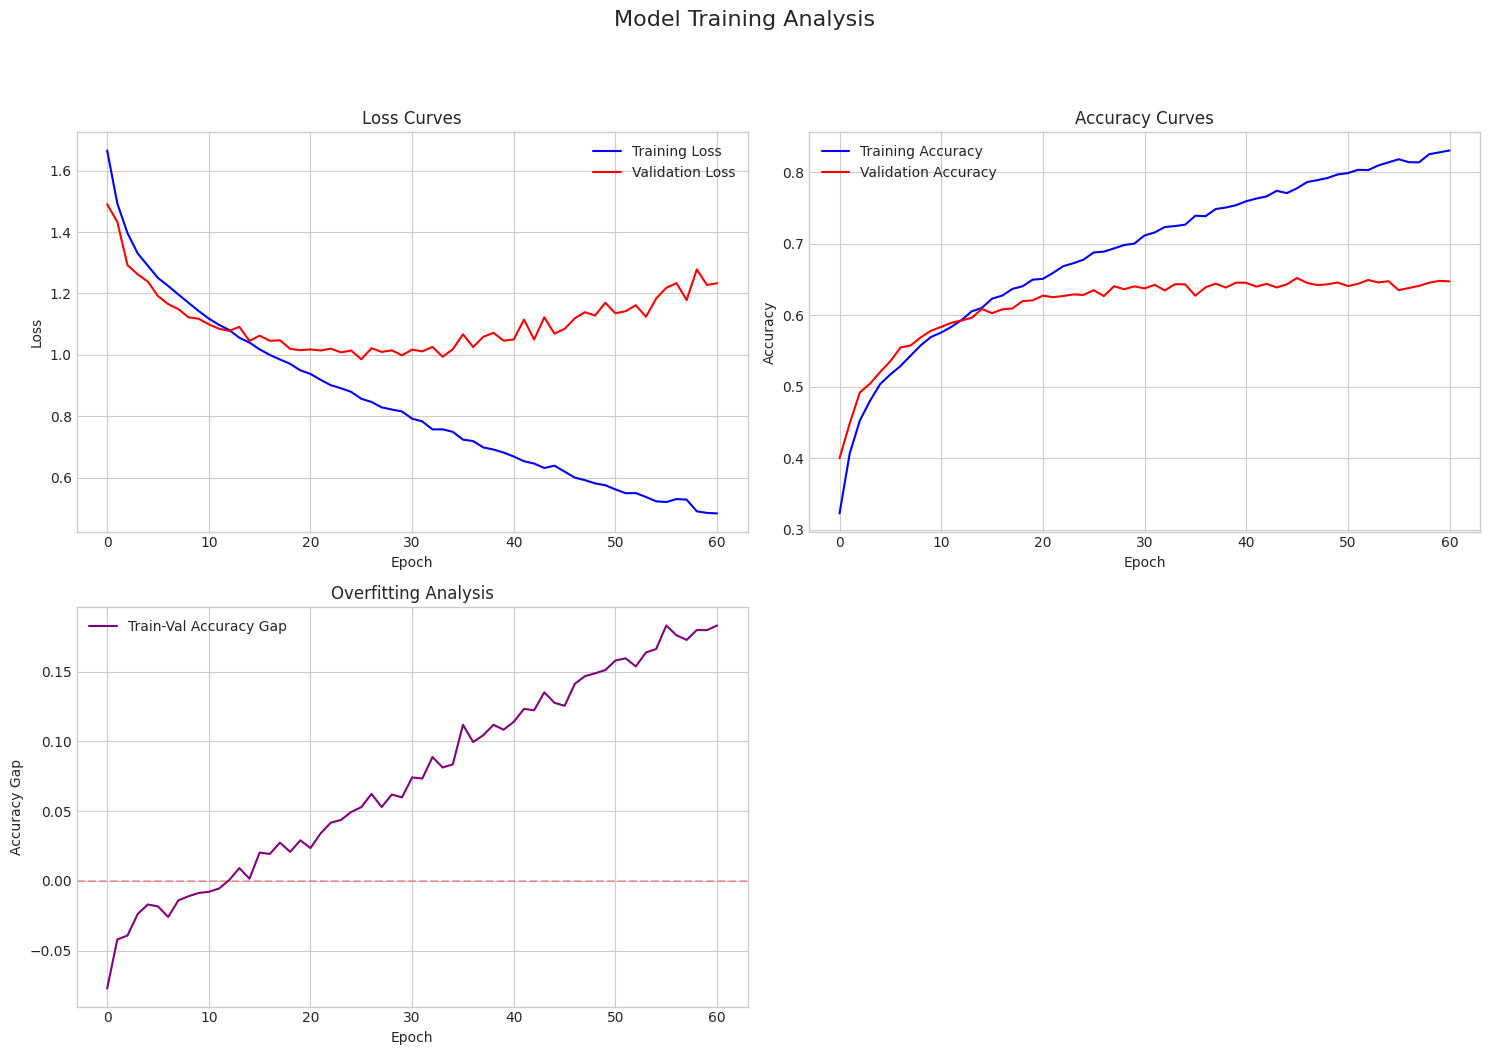

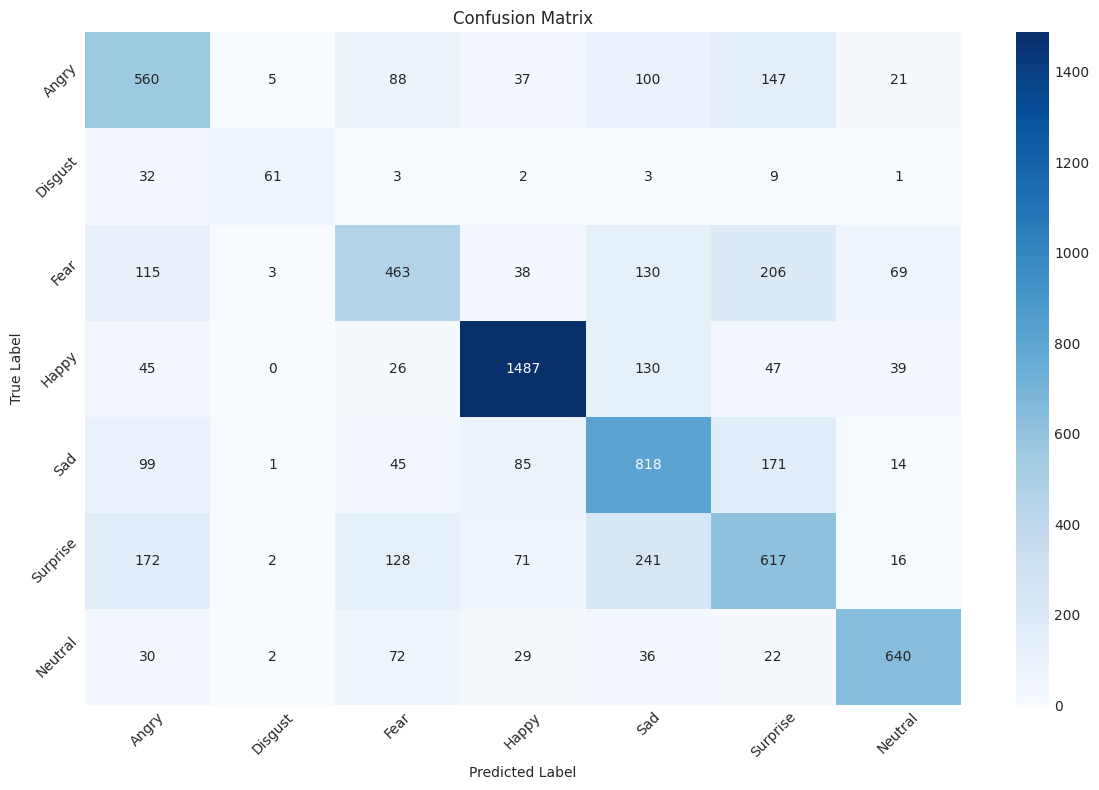


Classification Report:
              precision    recall  f1-score   support

       Angry       0.53      0.58      0.56       958
     Disgust       0.82      0.55      0.66       111
        Fear       0.56      0.45      0.50      1024
       Happy       0.85      0.84      0.84      1774
         Sad       0.56      0.66      0.61      1233
    Surprise       0.51      0.49      0.50      1247
     Neutral       0.80      0.77      0.78       831

    accuracy                           0.65      7178
   macro avg       0.66      0.62      0.64      7178
weighted avg       0.65      0.65      0.65      7178



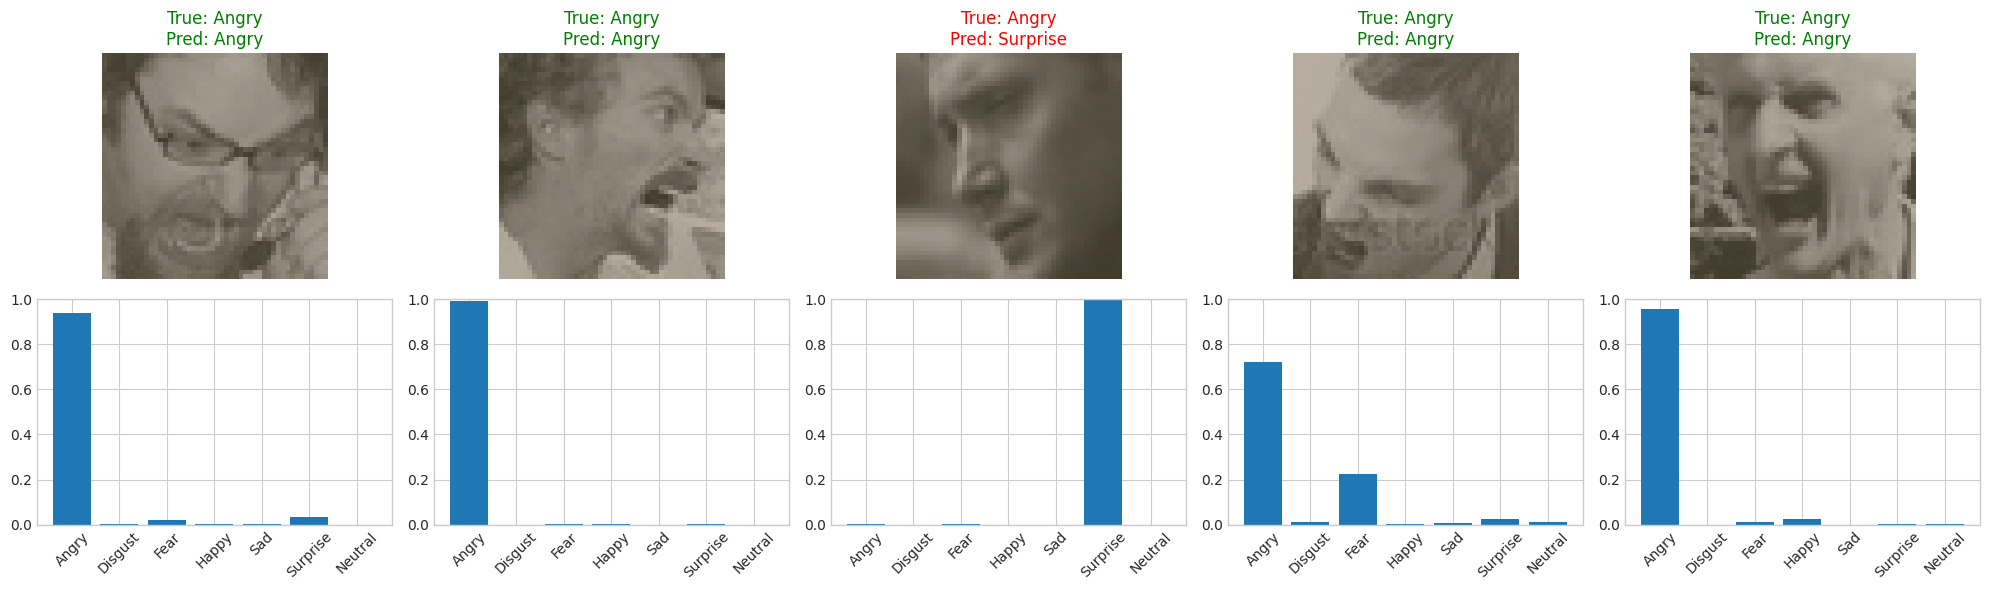

In [4]:
print_parameter_details(model)

pt_path, ptl_path = convert_all_formats('ResEmoteNetKAN_model.pth', 'ResEmoteNetKAN')

plot_training_curves(history)

# Definisikan nama kelas sesuai dengan dataset FER2013
class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Evaluasi model dan tampilkan confusion matrix
evaluate_model(model, val_loader, device, class_names)

# Tampilkan contoh prediksi
plot_sample_predictions(model, val_loader, device, class_names)